<a href="https://colab.research.google.com/github/catastropiyush/codes_samosa/blob/main/Astropy_sikho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import astropy.units as u
from astropy.utils.data import download_file
from astropy.io import fits  # We use fits to open the actual data file

from astropy.utils import data
data.conf.remote_timeout = 60
from spectral_cube import SpectralCube
from astroquery.esasky import ESASky
from astroquery.utils import TableList
from astropy.wcs import WCS
from reproject import reproject_interp

In [ ]:
pip install reproject

In [ ]:
pip install spectral_cube

In [ ]:
pip install astroquery

In [ ]:
# Downloads the HI data in a fits file format
hi_datafile = download_file(
    'http://data.astropy.org/tutorials/FITS-cubes/reduced_TAN_C14.fits',
    cache=True, show_progress=True)

In [ ]:
hi_data = fits.open(hi_datafile)  # Open the FITS file for reading
cube = SpectralCube.read(hi_data)  # Initiate a SpectralCube
hi_data.close()  # Close the FITS file - we already read it in and don't need it anymore!

In [ ]:
print(cube)

SpectralCube with shape=(450, 150, 150) and unit=K:
 n_x:    150  type_x: GLON-TAN  unit_x: deg    range:   286.727203 deg:  320.797623 deg
 n_y:    150  type_y: GLAT-TAN  unit_y: deg    range:   -50.336450 deg:  -28.401234 deg
 n_s:    450  type_s: VRAD      unit_s: m / s  range:  -598824.534 m / s:  600409.133 m / s


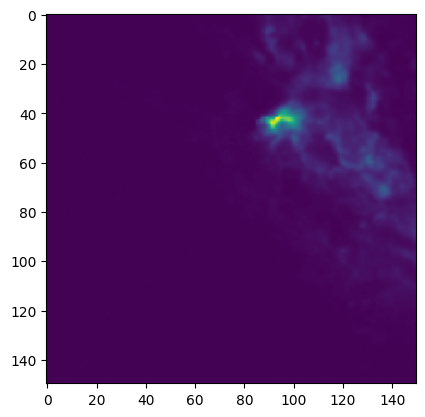

In [ ]:
cube[300, :, :].quicklook()  # Slice the cube along the spectral axis, and display a quick image

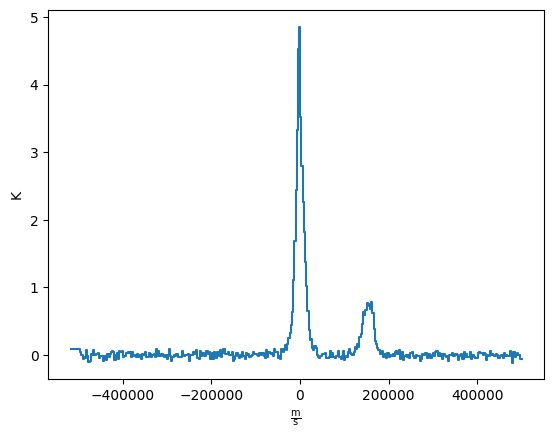

In [ ]:
cube[:,2,50].quicklook()  # Extract a single spectrum through the data cube
#    v:lat:lon

In [ ]:
_, b, _ = cube.world[0, :, 0]  #extract latitude world coordinates from cube
_, _, l = cube.world[0, 0, :]  #extract longitude world coordinates from cube

In [ ]:
# Define desired latitude and longitude range
lat_range = [-46, -40] * u.deg
lon_range = [306, 295] * u.deg

# Create a sub_cube cut to these coordinates
sub_cube = cube.subcube(xlo=lon_range[0], xhi=lon_range[1], ylo=lat_range[0], yhi=lat_range[1])
print(sub_cube)

SpectralCube with shape=(450, 38, 57) and unit=K:
 n_x:     57  type_x: GLON-TAN  unit_x: deg    range:   294.113498 deg:  306.009028 deg
 n_y:     38  type_y: GLAT-TAN  unit_y: deg    range:   -46.014280 deg:  -40.027398 deg
 n_s:    450  type_s: VRAD      unit_s: m / s  range:  -598824.534 m / s:  600409.133 m / s


In [ ]:
sub_cube_slab = sub_cube.spectral_slab(-300. *u.km / u.s, 300. *u.km / u.s)
print(sub_cube_slab)

SpectralCube with shape=(226, 38, 57) and unit=K:
 n_x:     57  type_x: GLON-TAN  unit_x: deg    range:   294.113498 deg:  306.009028 deg
 n_y:     38  type_y: GLAT-TAN  unit_y: deg    range:   -46.014280 deg:  -40.027398 deg
 n_s:    226  type_s: VRAD      unit_s: m / s  range:  -299683.842 m / s:  301268.441 m / s


In [ ]:
moment_0 = sub_cube_slab.with_spectral_unit(u.km/u.s).moment(order=0)  # Zero-th moment
moment_1 = sub_cube_slab.with_spectral_unit(u.km/u.s).moment(order=1)  # First moment

# Write the moments as a FITS image
# moment_0.write('hi_moment_0.fits')
# moment_1.write('hi_moment_1.fits')

print('Moment_0 has units of: ', moment_0.unit)
print('Moment_1 has units of: ', moment_1.unit)

# Convert Moment_0 to a Column Density assuming optically thin media
hi_column_density = moment_0 * 1.82 * 10**18 / (u.cm * u.cm) * u.s / u.K / u.km

Moment_0 has units of:  K km / s
Moment_1 has units of:  km / s


In [ ]:
print(moment_1.wcs)  # Examine the WCS object associated with the moment map

WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-TAN'  'GLAT-TAN'  
CRVAL : 303.75  -40.0  
CRPIX : 11.557620817843869  40.3723930634757  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.1494444443846667  0.1538888888273333  
NAXIS : 0  0


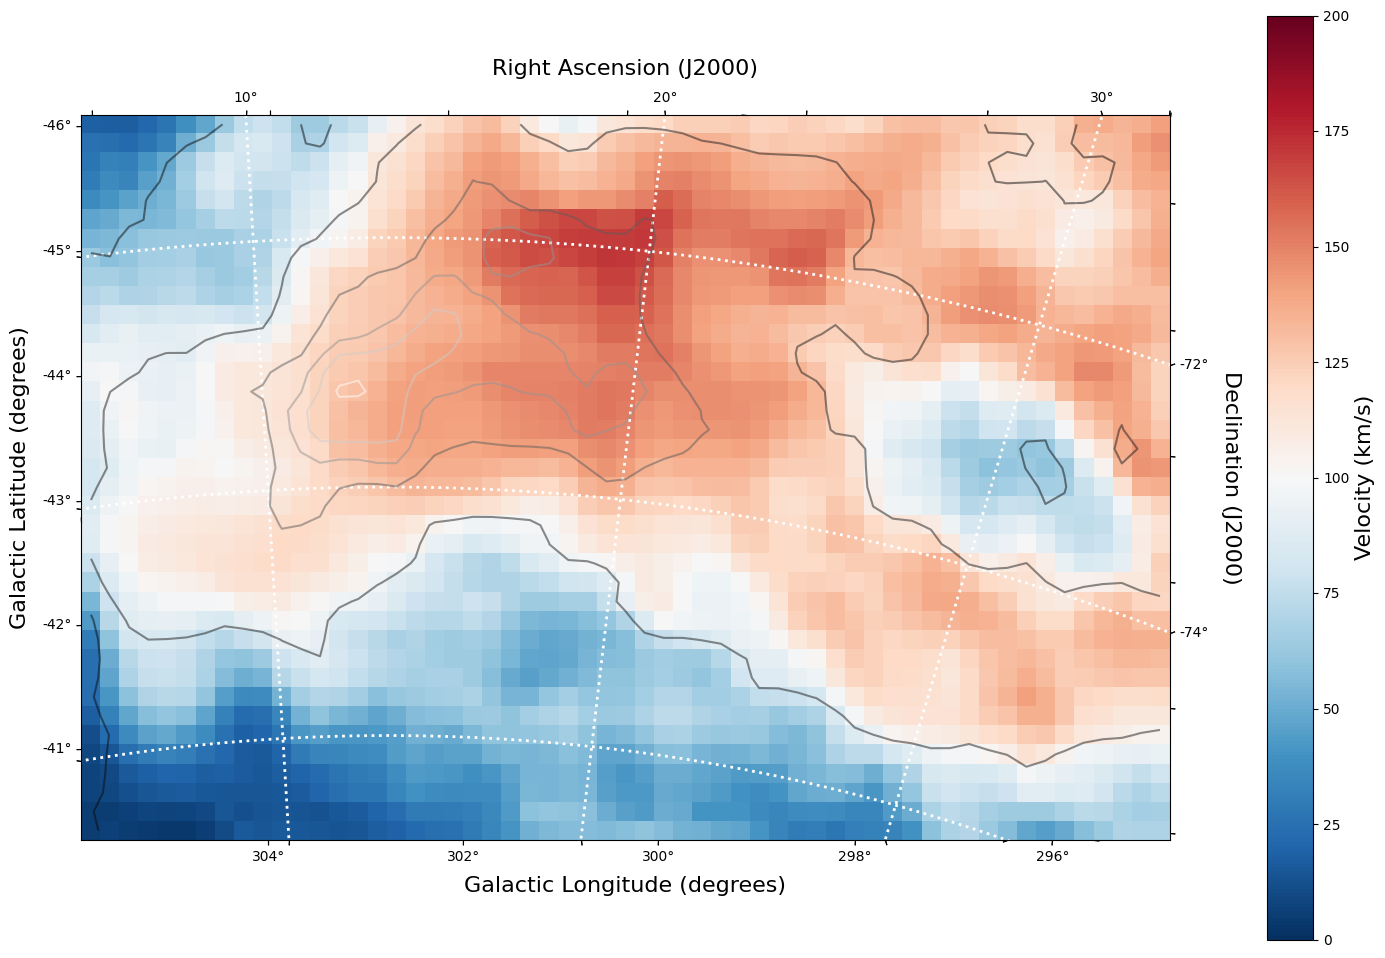

In [ ]:
# Initiate a figure and axis object with WCS projection information
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection=moment_1.wcs)
# Display the moment map image
im = ax.imshow(moment_1.hdu.data, cmap='RdBu_r', vmin=0, vmax=200)
ax.invert_yaxis()  # Flips the Y axis
# Add axes labels
ax.set_xlabel("Galactic Longitude (degrees)", fontsize=16)
ax.set_ylabel("Galactic Latitude (degrees)", fontsize=16)
# Add a colorbar
cbar = plt.colorbar(im, pad=.07)
cbar.set_label('Velocity (km/s)', size=16)
# Overlay set of RA/Dec Axes
overlay = ax.get_coords_overlay('fk5')
overlay.grid(color='white', ls='dotted', lw=2)
overlay[0].set_axislabel('Right Ascension (J2000)', fontsize=16)
overlay[1].set_axislabel('Declination (J2000)', fontsize=16)
# Overplot column density contours
levels = (1e20, 5e20, 1e21, 3e21, 5e21, 7e21, 1e22)  # Define contour levels to use
ax.contour(hi_column_density.hdu.data, cmap='Greys_r', alpha=0.5, levels=levels)

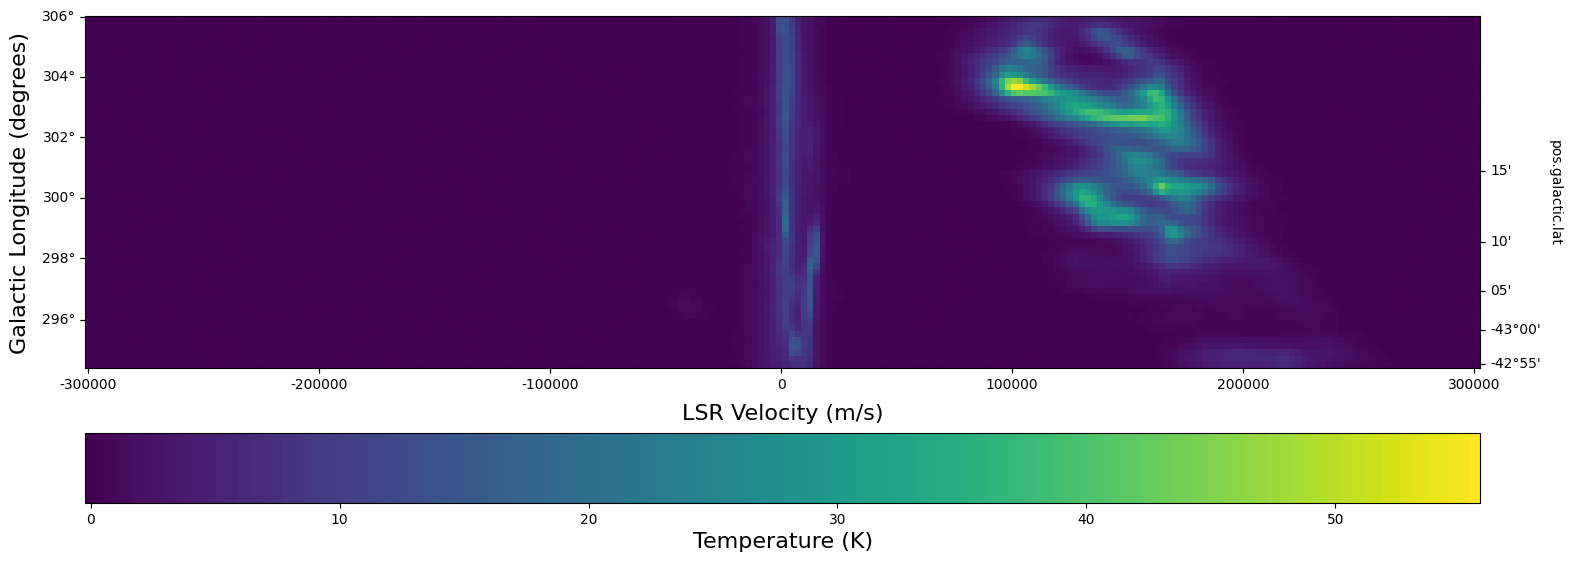

In [ ]:
lat_slice = 18  # Index of latitude dimension to slice along
# Initiate a figure and axis object with WCS projection information
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection=sub_cube_slab.wcs, slices=('y', lat_slice, 'x'))
# Above, we have specified to plot the longitude along the y axis, pick only the lat_slice
# indicated, and plot the velocity along the x axis
# Display the slice
im = ax.imshow(sub_cube_slab[:, lat_slice, :].transpose().data)  # Display the image slice
ax.invert_yaxis()  # Flips the Y axis

# Add axes labels
ax.set_xlabel("LSR Velocity (m/s)", fontsize=16)
ax.set_ylabel("Galactic Longitude (degrees)", fontsize=16)

# Add a colorbar
cbar = plt.colorbar(im, pad=.07, orientation='horizontal')
cbar.set_label('Temperature (K)', size=16)

In [ ]:
sub_cube_slab

#Gaia Data
https://allendowney.github.io/AstronomicalData/01_query.html

In [ ]:
pip install astroquery

In [ ]:
from astroquery.gaia import Gaia

#Astropy


In [ ]:
#Aug 27,2023

https://astro-330.github.io/Lecture2/Lecture2.html  \\
https://prappleizer.github.io/

In [2]:
import astropy

In [12]:
import numpy as np

In [8]:
class Body():
    def __init__(self,name,mass,radius):
        self.name = name
        self.mass = mass
        self.radius = radius
    def calc_density(self):
        vol = (4/3.) * np.pi * self.radius**3
        return (self.mass / vol).to((u.g/u.cm**3))

In [5]:
import astropy.units as u
sun = Body('Sun',1*u.Msun,1*u.Rsun)

In [7]:
sun.mass

<Quantity 1. solMass>

In [13]:
sun = Body('Sun',1*u.Msun,1*u.Rsun)
sun.calc_density()

<Quantity 1.40977982 g / cm3>